# Dawring To Drawing

In [2]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

Image Size Standard

In [3]:
image_size = (28, 28)

## Acquisition

In [4]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

## Test Train Validation Split

In [5]:
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 412800 files belonging to 345 classes.
Using 330240 files for training.
Found 412800 files belonging to 345 classes.
Using 82560 files for validation.


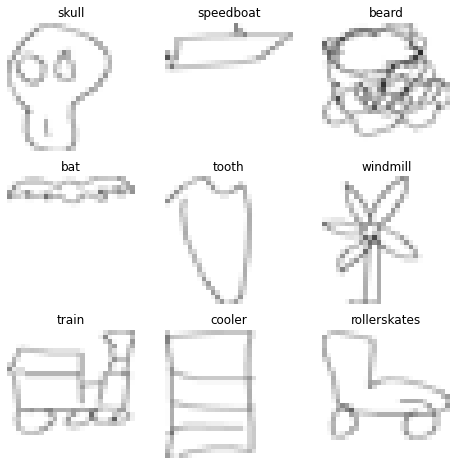

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

## Modelling

In [7]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         440       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 10)       40        
 hNormalization)                                        

## Training

In [8]:
epochs = 14

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

model.save('models/model_20220814-115719')

Epoch 1/14
10320/10320 [==============================] - 1149s 111ms/step - loss: 2.8881 - accuracy: 0.3315 - val_loss: 2.2192 - val_accuracy: 0.4486
Epoch 2/14
10320/10320 [==============================] - 803s 78ms/step - loss: 2.1585 - accuracy: 0.4583 - val_loss: 1.7726 - val_accuracy: 0.5417
Epoch 3/14
10320/10320 [==============================] - 795s 77ms/step - loss: 1.9239 - accuracy: 0.5063 - val_loss: 1.7416 - val_accuracy: 0.5497
Epoch 4/14
10320/10320 [==============================] - 785s 76ms/step - loss: 1.7896 - accuracy: 0.5348 - val_loss: 1.7344 - val_accuracy: 0.5504
Epoch 5/14
10320/10320 [==============================] - 778s 75ms/step - loss: 1.6937 - accuracy: 0.5544 - val_loss: 1.6211 - val_accuracy: 0.5785
Epoch 6/14
10320/10320 [==============================] - 771s 75ms/step - loss: 1.6262 - accuracy: 0.5686 - val_loss: 1.5987 - val_accuracy: 0.5797
Epoch 7/14
10320/10320 [==============================] - 772s 75ms/step - loss: 1.5730 - accuracy: 0.58

INFO:tensorflow:Assets written to: ./models/model_20220814-115719\assets


INFO:tensorflow:Assets written to: ./models/model_20220814-115719\assets


## Storing

In [9]:
converter = tf.lite.TFLiteConverter.from_saved_model("models/model_20220814-115719")
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)